# Assignment 1 - LS on 3rd order polynomial

In [120]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import laplace, norm
from typing import Callable

## Selecting model-order and Generating data
Here we will generate a synthetic dataset from a n-th order polynomial model **$y = \theta_0  + \theta_1 \cdot u^1 + ... + \theta_n \cdot u^n $** and add some noise, with known distribution, to simulate sampling of the data, giving us **$y_{measured} = y + noise$**,  where:  
$y$ = output  
$u$ = input    
$\theta_{0,1,...,n}$ = model parameters   
$noise$ = measurement noise

Given the genreated input data $u$ and the measured data **$y_{measured}$** we will try to estimate the polynomial model coeffitienst $\hat{\theta}_{0,1,...,n}$ using the Least sqaures (LS) and Maximum likelihood estimate (MLE) methods.

### Model-order selection 
The "params" vector decides the order of the selected model, make sure to put in \$n+1\$ parameters into the vector for the get a model of order \$n\$, the first parameter \$\theta_0\$ is the bias term

In [149]:
def arbitrary_poly(params):
    poly_model = lambda x: sum([p*(x**i) for i, p in enumerate(params)])
    return poly_model

In [150]:
# params: [theta_0, theta_1, ... , theta_n], where n = model order and theta_0 is bias 
true_params = [1,-8,4]
n_params = len(true_params)
y_model = arbitrary_poly(true_params)

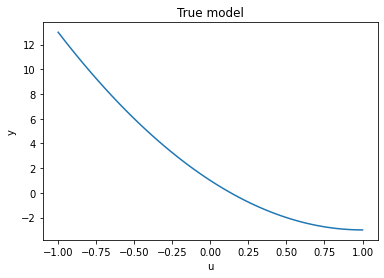

In [122]:
# Plot true model
x = np.linspace(start=-1, stop=1, num=100)
plt.figure()
plt.plot(x, y_model(x))
plt.xlabel("u")
plt.ylabel("y")
plt.title("True model")
plt.show()

## Measurement noise generation from a chosen distribution
Probability density functions (PDFs):

Gaussian pdf: $P_N(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2}$

Laplacian pdf: $P_L(x) = \frac{1}{2b}e^{-\frac{|x-\mu|}{b}}$

Mixture model: $P(x) = \alpha P_N(x) + (1-\alpha) P_L(x)$

Hyperparameters to adjust:
- mu: The distribution's location parameter (mean value for Gauss).
- sigma: The distribution's scaling parameter (std. for Gauss).
- magnitude: The noise magnitude.
- N: number of samples to generate for the model.
- alpha: the mixture weight for gaussian.

In [123]:
class GaussParams:
    def __init__(self, mean: float, std: float):
        self.mean = mean
        self.std = std
        self.var = std**2

        # aliases, these are the names used in scipy.stats functions
        self.loc = self.mean
        self.scale = self.std

    def __iter__(self):  # to allow tuple unpacking
        return iter((self.mean, self.std))


class LaplaceParams:
    def __init__(self, mean: float, beta: float):
        self.mean = mean
        self.beta = beta
        
        # aliases, these are the names used in scipy.stats functions
        self.loc = self.mean
        self.shape = self.beta

    def __iter__(self):  # to allow tuple unpacking
        return iter((self.mean, self.beta))

In [148]:
# Hyperparameters for the type of noise-generating distribution.
## Gauss
loc_gauss = 0  # mean
scale_gauss = 1  # std
gauss_params = GaussParams(loc_gauss, scale_gauss)
## Lapalce
loc_laplace = 0    # mean
scale_laplace = 1  # beta
laplace_params = LaplaceParams(loc_laplace, scale_laplace)
## Mixture
alpha = 0.5

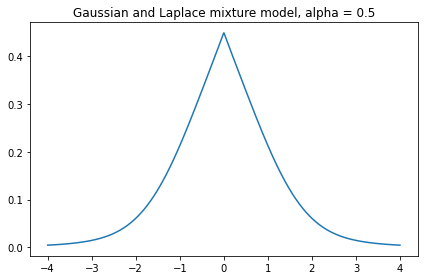

In [147]:
# The Laplace probability density function: available in library "scipy.stats.laplace"
# The Gaussian probability density function: available in library "scipy.stats.norm"
def mixture_pdf(x, alpha):
    return alpha * norm.pdf(x, loc_gauss, scale_gauss) + (1-alpha) * laplace.pdf(x, loc_laplace, scale_laplace)

# Plot noise distribution
loc = alpha * loc_gauss + (1-alpha) * loc_laplace
scale = alpha * scale_gauss + (1-alpha) * scale_laplace
n = np.linspace(start=(loc - 4*scale), stop=(loc + 4*scale), num=1000)  # input range centered around mean of pdf

fig, ax = plt.subplots()
ax.plot(n, mixture_pdf(n, alpha))
ax.set_title(f"Gaussian and Laplace mixture model, alpha = {alpha}")
plt.tight_layout()
plt.show()

### Data generation:

In [125]:
def generate_noise(N: int, magnitude: float, alpha: float, gauss_params: GaussParams, laplace_params: LaplaceParams) -> np.ndarray:
    """
    Generate noise based on the mixture model: alpha * gaussian + (1 - alpha) * laplacian.
    Args:
        N: number of noise points to generate.
        magnitude: the noise amplitude/magnitude.
        alpha: fraction of guassian and laplacian, should be in interval [0, 1].
        gauss_params: mean and std of gaussian distribution
        laplace_params: mean and beta of laplacian distribution
    Returns:
        A list of N noise points.
    """
    noise = alpha * np.random.normal(*gauss_params, N) + \
        (1 - alpha) * np.random.laplace(*laplace_params, N)
    noise *= magnitude

    return noise

In [126]:
# Hyperparameters for noise generation
magnitude = 1.2  # noise magnitude
N = 20           # number of samples

# Setup RNG
np.random.seed(0)  # Non-random generation between code executions. Comment out for true random

# Generate data points
range_low = -1
range_high = 1
u = np.sort(np.random.uniform(range_low, range_high, N))
y_true = y_model(u)

# Add noise to the generated data points - thus simulating measurement
noise = generate_nosie(N, magnitude, alpha, )
y = y_true + noise


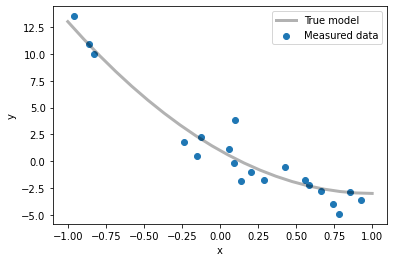

In [127]:
# Plot measured data
u0 = np.linspace(range_low, range_high, N)
plt.plot(u0, y_model(u0), "k", alpha=0.3, lw=3, label="True model")
plt.scatter(u, y, label="Measured data")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Least squares regression - LS
### Given the sampled data we can estimate the underlying polynomial model using LS regression
Solution to a least squares problem is given by the normal equation:  
$\hat{\mathbf{\theta}} = (\mathbf{u}^T\cdot \mathbf{u})^{-1}(\mathbf{u}^T\cdot \mathbf{y})$

---

### Step 1 - rewrite the model in matrix form to get the data tensor u

$y_{measured} = \theta_0  + \theta_1 \cdot u^1 + ... + \theta_n \cdot u^n  + noise =   [1 \; u^1 \; .. \; u^n] \cdot [ \theta_0 \; \theta_1 \; .. \; \theta_n ] ^T + noise$

$\mathbf{u} = [1 \; u^1 \; .. \; u^n]$


### Step 2   

calculate $(\mathbf{u}^T \cdot \mathbf{u})^{-1}$


### Step 3  

calculating dot productcalculate $(\mathbf{u}^T \cdot \mathbf{y})$


### Step 4 

solve for $\hat{\mathbf{\theta}} = (\mathbf{u}^T\cdot \mathbf{u})^{-1}(\mathbf{u}^T\cdot \mathbf{y})$



In [128]:
def least_square(u: np.ndarray, y: np.ndarray, n_params: int) -> np.ndarray:
    """
    Uses least sqaure (LS) to make the best fitting list of parameters.
    Args:
        u: data x values, shape = (N_samples,)
        y: data y values, shape = (N_samples,)
        n_params: number of parameters to find
    """
    N = u.shape[0]
    
    # Create data tensor
    u_tensor = np.ones((N,1))
    for i in range(1, n_params):
        u_tensor = np.append(u_tensor, np.power(u.reshape((-1,1)), i), axis=1)

    # Solve for LS params
    u_dot_u = u_tensor.T @ u_tensor
    u_dot_y = u_tensor.T @ y
    ls_params = np.linalg.solve(u_dot_u, u_dot_y)

    return ls_params


In [145]:
def ls_statistics(
    u: np.ndarray,
    y: np.ndarray, 
    true_params: np.ndarray, 
    ls_params_estimate: np.ndarray) -> tuple:
    """
    Calculate statistics on LS performance. 
    Args:
        u: data points x value.
        y: measured data points (with noise).
        true_params: list of the true parameters.
        ls_params_estimate: list of the LS parameters estimates.
    Returns:
        Tuple on the form 
            (RMSE, d) 
        where d is the Euclidean distance between the true and estimated parameters.
    """
    ls_model = arbitrary_poly(ls_params_estimate)
    rmse = np.sqrt(np.mean( (ls_model(u) - y)**2 ))
    d = np.linalg.norm( ls_params_estimate - np.array(true_params) )

    return rmse, d


LS parameters:         [0.91, -8.41, 3.87]
True model parameters: [1, -8, 4]


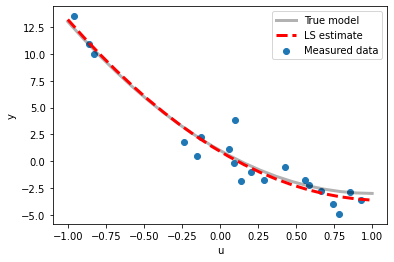

In [133]:
ls_params = least_square(u, y, n_params)
ls_params_rounded = [round(i, 2) for i in ls_params]
print(f"LS parameters:         {ls_params_rounded}")
print(f"True model parameters: {true_params}")

# Recreate model based on LS estimate:
LS_estimate_model = arbitrary_poly(ls_params)

# Plot true vs. estimated model
u0 = np.linspace(range_low, range_high, N)
plt.plot(u0, y_model(u0), "k", alpha=0.3, lw=3, label="True model")
plt.plot(u0, LS_estimate_model(u0), "r--",  lw=3, label="LS estimate")
plt.scatter(u, y, label=r"Measured data")
plt.legend()
plt.xlabel("u")
plt.ylabel("y")
plt.show()

In [146]:
rmse_ls = np.sqrt(np.mean((LS_estimate_model(u)-y)**2))
params_dist_ls = np.linalg.norm( LS_params - np.array(true_params) )
print(f"LS - RMSE:  {rmse_ls}")
print(f"Euclidean norm between parameters: d = {params_dist_ls}")


rmse, d = ls_statistics(u, y, true_params, ls_params)
print(rmse, d)



LS - RMSE:  1.235527516557913
Euclidean norm between parameters: d = 0.43742494007456534
1.235527516557913 0.43742494007456534
